In [ ]:
print(2)

In [ ]:
print(4)x

In [ ]:
from tabpfn import TabPFNClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
surdiagonal_distances = np.linspace(0.0, 10.0, 10)
classifier = TabPFNClassifier(no_preprocess_mode=True, normalize=False)

n_points_each = 600
X_true = np.random.randn(n_points_each, 2)
X_true[:, 1] = X_true[:, 0] + 0.2 * np.random.randn(n_points_each)

for i in range(10):
    # create points on the surdiagonals
    X_false = np.zeros((n_points_each, 2))
    X_false[:, 0] = np.random.randn(n_points_each)
    # make points both on the upper and lower surdiagonals
    X_false[:len(X_false)//2, 1] = X_false[:len(X_false)//2, 0] + surdiagonal_distances[i] + 0.2 * np.random.randn(len(X_false)//2)
    X_false[len(X_false)//2:, 1] = X_false[len(X_false)//2:, 0] - surdiagonal_distances[i] + 0.2 * np.random.randn(len(X_false)//2)
    X = np.concatenate((X_true, X_false))
    y = np.concatenate((np.ones(n_points_each), np.zeros(n_points_each)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test)[:, 1]
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', s=10)
    plt.colorbar()
    plt.show()

In [18]:
import pickle
# load data_for_plot
with open('data_for_plot.pkl', 'rb') as f:
    data_for_plot = pickle.load(f)

59


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


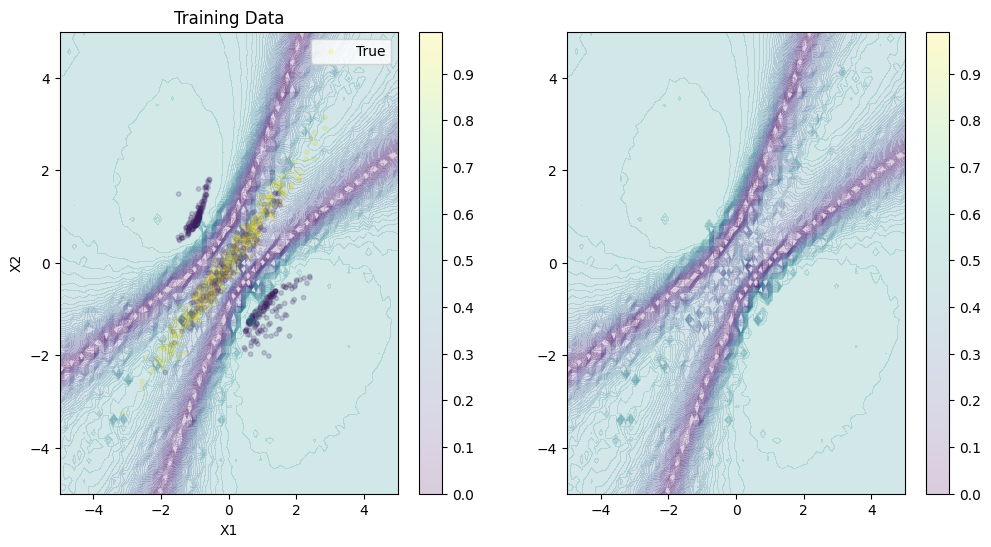

In [24]:
import copy
import torch
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# set axis limits
# axs[0].set_xlim(-3, 3)
# axs[0].set_ylim(-3, 3)
# axs[1].set_xlim(-3, 3)
# axs[1].set_ylim(-3, 3)

#frame = n_step_test_factor * 4 - 10
print(len(data_for_plot))
frame = -1

device = "cuda:0"


axs[0].clear()
axs[1].clear()

X_train_to_plot, X_test_to_plot, y_train_to_plot, y_test_to_plot, _, _ = data_for_plot[frame]

#X_train_to_plot_copy = torch.tensor(X_train.cpu().detach().numpy().copy()).float().to(device)
#X_train_to_plot_copy[y_train_to_plot == 1] = normalize_data(X_train_to_plot_copy[y_train_to_plot == 1])

axs[0].scatter(X_train_to_plot[:, 0], X_train_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_train_to_plot)
axs[0].set_title("Training Data")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].legend()

# axs[1].scatter(X_test_to_plot[:, 0], X_test_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_test_to_plot)
# axs[1].set_title("Test Data")
# axs[1].set_xlabel("X1")
# axs[1].set_ylabel("X2")
# axs[1].legend()

# compute decision boundaries
# Train a classifier on the training data
#classifier = RandomForestClassifier()
tabpfn_classifier2 = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=True, no_grad=False,
                                        normalize=False)
tabpfn_classifier2.fit(torch.tensor(X_train_to_plot).to(device), y_train_to_plot, overwrite_warning=True)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 70), np.linspace(y_min, y_max, 70))

# Compute the probability estimates for each class
#input_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
input_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
# add a random third feature
input_data = torch.cat((input_data, torch.randn(input_data.shape[0], 1).to(device)), dim=1)
Z = np.abs(tabpfn_classifier2.predict_proba(input_data)[:, 1].reshape(xx.shape).detach().cpu().numpy() - 0.5)
#Z = tabpfn_classifier2.predict_proba(input_data)[:, 1].reshape(xx.shape).detach().cpu().numpy()

# # Plot decision boundary on training data plot with confidence
contour0 = axs[0].contourf(xx, yy, Z, alpha=0.2, levels=np.linspace(0, 1, 100), cmap='viridis', zorder=1)
axs[0].contour(xx, yy, Z, colors='k', levels=[0.5], linestyles=['-'], zorder=2)

# Plot decision boundary on test data plot with confidence
contour1 = axs[1].contourf(xx, yy, Z, alpha=0.2, levels=np.linspace(0, 1, 100), cmap='viridis', zorder=1)
axs[1].contour(xx, yy, Z, colors='k', levels=[0.5], linestyles=['-'], zorder=2)

# # Add colorbars to show the confidence levels
fig.colorbar(contour0, ax=axs[0], format='%0.1f')
fig.colorbar(contour1, ax=axs[1], format='%0.1f')

plt.show()


# if frame % n_step_test_factor == 0:
#     # make the background light red
#     axs[0].set_facecolor((1.0, 0.9, 0.9))
#     axs[1].set_facecolor((1.0, 0.9, 0.9))
# else:
#     axs[0].set_facecolor((1.0, 1.0, 1.0))
#     axs[1].set_facecolor((1.0, 1.0, 1.0))

# compute rf accuracy
# rf.fit(X.cpu().detach().numpy()[:single_eval_pos], y.cpu().numpy()[:single_eval_pos])
# y_pred_rf = rf.predict(X.cpu().detach().numpy()[single_eval_pos:])
# accuracy_rf = accuracy_score(y.cpu().numpy()[single_eval_pos:], y_pred_rf)
# print(f"Accuracy RF: {accuracy_rf}")
    
    #plt.tight_layout()

59


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


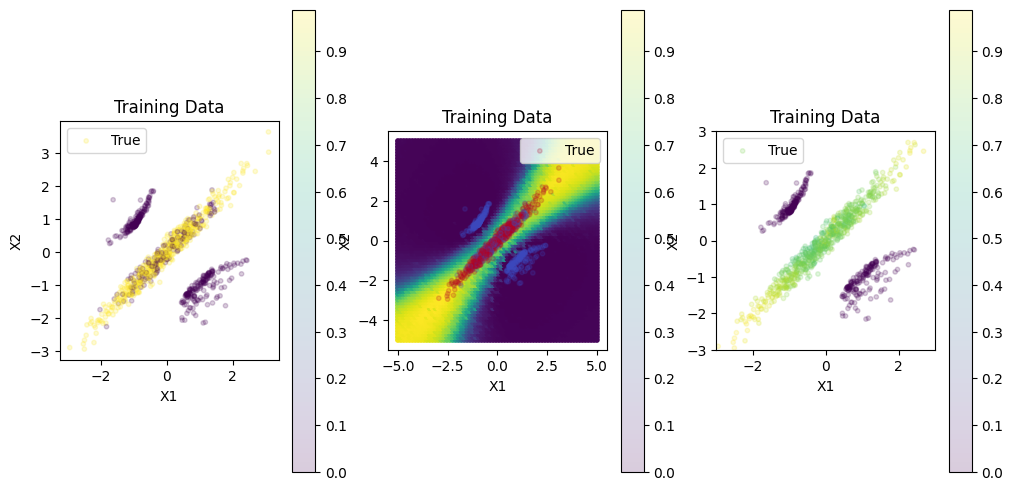

In [46]:
import copy
import torch
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
# set axis limits
axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)
axs[1].set_xlim(-3, 3)
axs[1].set_ylim(-3, 3)
axs[2].set_xlim(-3, 3)
axs[2].set_ylim(-3, 3)
# aspect ratio
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

#frame = n_step_test_factor * 4 - 10
print(len(data_for_plot))
frame = -10

device = "cuda:0"


axs[0].clear()
axs[1].clear()

X_train_to_plot, X_test_to_plot, y_train_to_plot, y_test_to_plot, _, _ = data_for_plot[frame]

#X_train_to_plot_copy = torch.tensor(X_train.cpu().detach().numpy().copy()).float().to(device)
#X_train_to_plot_copy[y_train_to_plot == 1] = normalize_data(X_train_to_plot_copy[y_train_to_plot == 1])

# make colors blue and red
axs[0].scatter(X_train_to_plot[:, 0], X_train_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_train_to_plot)
axs[0].set_title("Training Data")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].legend()

# axs[1].scatter(X_test_to_plot[:, 0], X_test_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_test_to_plot)
# axs[1].set_title("Test Data")
# axs[1].set_xlabel("X1")
# axs[1].set_ylabel("X2")
# axs[1].legend()

# compute decision boundaries
# Train a classifier on the training data
#classifier = RandomForestClassifier()
tabpfn_classifier2 = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=True, no_grad=False,
                                        normalize=False)
tabpfn_classifier2.fit(torch.tensor(X_train_to_plot).to(device), y_train_to_plot, overwrite_warning=True)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 70), np.linspace(y_min, y_max, 70))

# Compute the probability estimates for each class
#input_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
input_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
# add a random third feature
input_data = torch.cat((input_data, torch.randn(input_data.shape[0], 1).to(device)), dim=1)
#Z = np.abs(tabpfn_classifier2.predict_proba(input_data)[:, 1].reshape(xx.shape).detach().cpu().numpy() - 0.5)
Z = tabpfn_classifier2.predict_proba(input_data)[:, 1].reshape(xx.shape).detach().cpu().numpy()

# # # Plot decision boundary on training data plot with confidence
# contour0 = axs[0].contourf(xx, yy, Z, alpha=0.2, levels=np.linspace(0, 1, 100), cmap='viridis', zorder=1)
# axs[0].contour(xx, yy, Z, colors='k', levels=[0.5], linestyles=['-'], zorder=2)

# # Plot decision boundary on test data plot with confidence
# contour1 = axs[1].contourf(xx, yy, Z, alpha=0.2, levels=np.linspace(0, 1, 100), cmap='viridis', zorder=1)
# axs[1].contour(xx, yy, Z, colors='k', levels=[0.5], linestyles=['-'], zorder=2)
axs[1].scatter(xx, yy, c=Z, cmap='viridis', s=10)

# # Add colorbars to show the confidence levels
fig.colorbar(contour0, ax=axs[0], format='%0.1f')
fig.colorbar(contour1, ax=axs[1], format='%0.1f')

axs[1].scatter(X_train_to_plot[:, 0], X_train_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_train_to_plot, cmap='coolwarm')
axs[1].set_title("Training Data")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].legend()


y_pred = tabpfn_classifier2.predict_proba(torch.tensor(X_train_to_plot).to(device),)[:, 1].detach().cpu().numpy()
axs[2].scatter(X_train_to_plot[:, 0], X_train_to_plot[:, 1], label="True", s=10, alpha=0.2, c=y_pred)
axs[2].set_title("Training Data")
axs[2].set_xlabel("X1")
axs[2].set_ylabel("X2")
axs[2].legend()
# colorbar
fig.colorbar(contour0, ax=axs[2], format='%0.1f')

plt.show()


# if frame % n_step_test_factor == 0:
#     # make the background light red
#     axs[0].set_facecolor((1.0, 0.9, 0.9))
#     axs[1].set_facecolor((1.0, 0.9, 0.9))
# else:
#     axs[0].set_facecolor((1.0, 1.0, 1.0))
#     axs[1].set_facecolor((1.0, 1.0, 1.0))

# compute rf accuracy
# rf.fit(X.cpu().detach().numpy()[:single_eval_pos], y.cpu().numpy()[:single_eval_pos])
# y_pred_rf = rf.predict(X.cpu().detach().numpy()[single_eval_pos:])
# accuracy_rf = accuracy_score(y.cpu().numpy()[single_eval_pos:], y_pred_rf)
# print(f"Accuracy RF: {accuracy_rf}")
    
    #plt.tight_layout()

In [ ]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Number of samples to generate
num_samples = 1400

# Generate points randomly chosen from -1 and 1
points = np.random.choice([-1, 1], size=num_samples)

# Initialize labels array
labels = np.zeros(num_samples)

# Assign labels based on the given probabilities
for i, point in enumerate(points):
    if point == 1:
        labels[i] = np.random.choice([1, 0], p=[0.95, 0.05])
    else:
        labels[i] = np.random.choice([1, 0], p=[0.05, 0.95])

X, y = points.reshape(-1, 1), labels

print(X.shape, y.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier()
tabpfn = TabPFNClassifier(device=device, N_ensemble_configurations=1, no_preprocess_mode=True, normalize=False)
tabpfn.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_tabpfn = tabpfn.predict(X_test)
y_pred_rf = rf.predict(X_test)

accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy tabpfn: {accuracy_tabpfn}")
print(f"Accuracy RF: {accuracy_rf}")

plt.scatter(X_train, y_train, label="True", s=10, alpha=0.2)  
plt.scatter(X_test, y_test, label="True", s=10, alpha=0.2)






In [63]:
np.arange(10, 512, 50)

array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510])

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


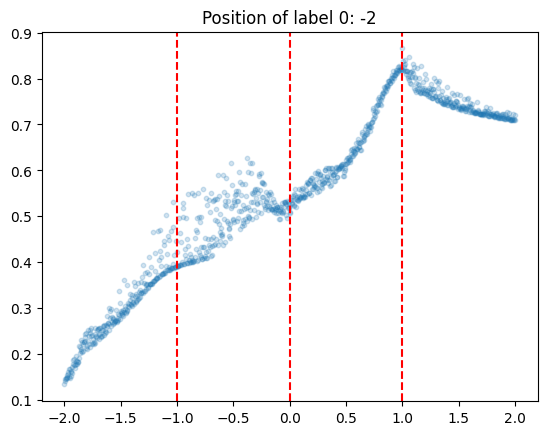

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


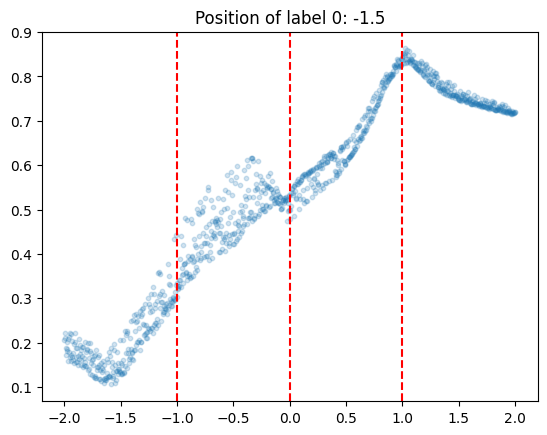

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


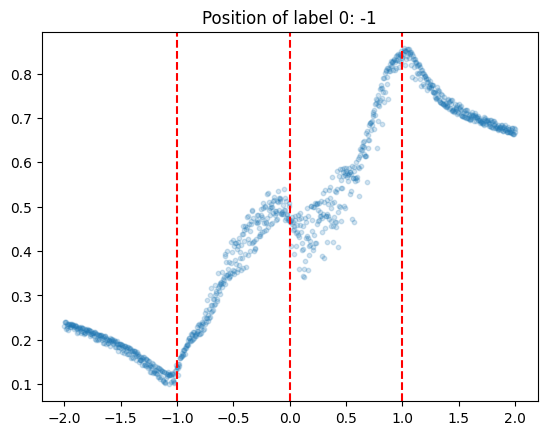

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


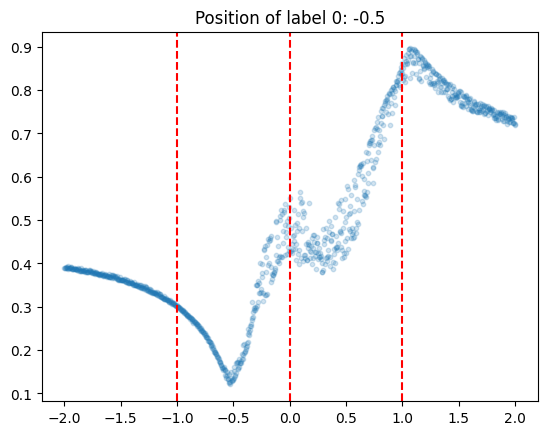

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


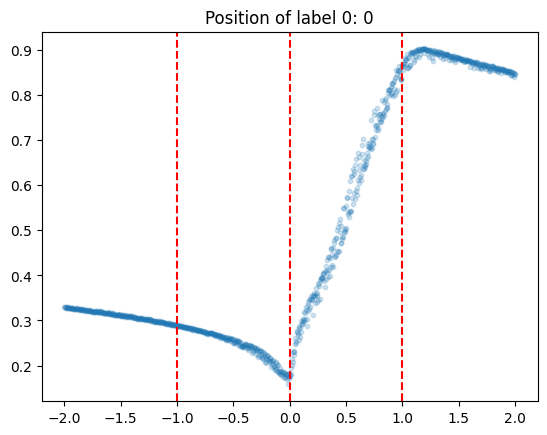

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


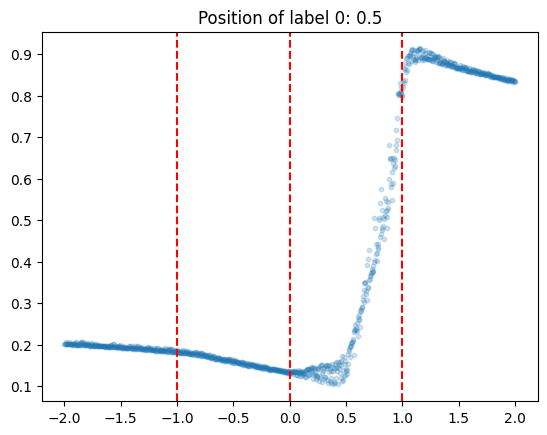

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


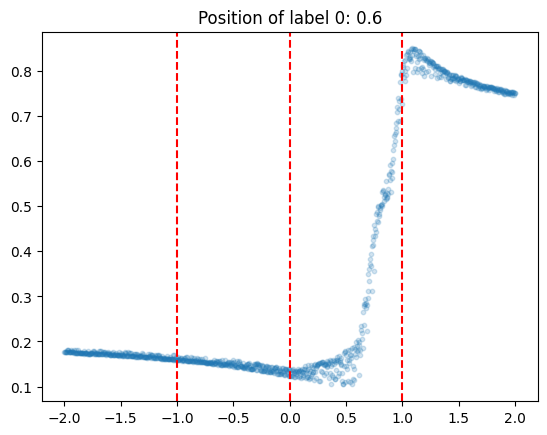

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


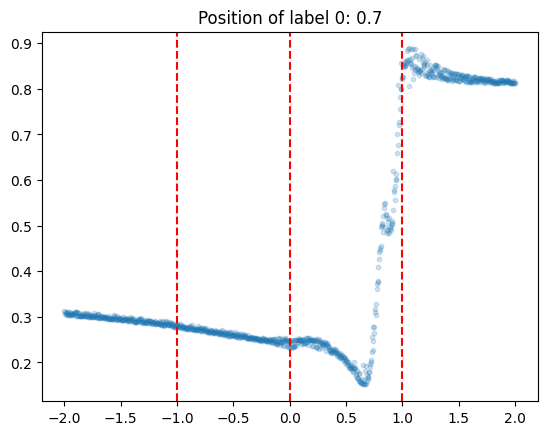

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


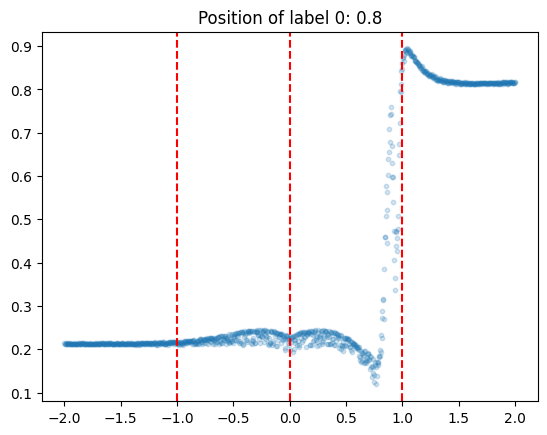

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


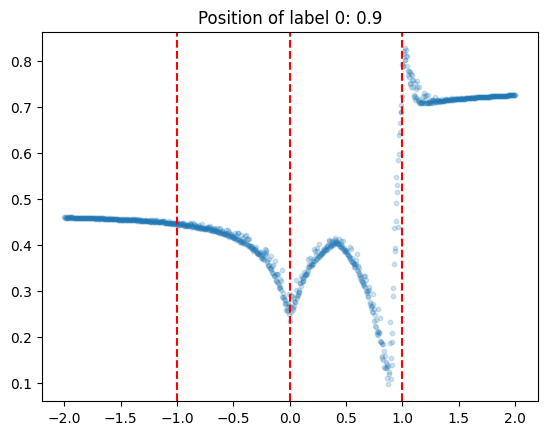

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


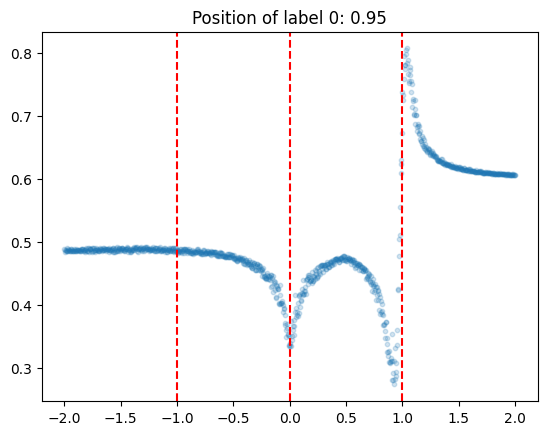

(512, 2) (512, 2)
(1024, 2) (1024,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


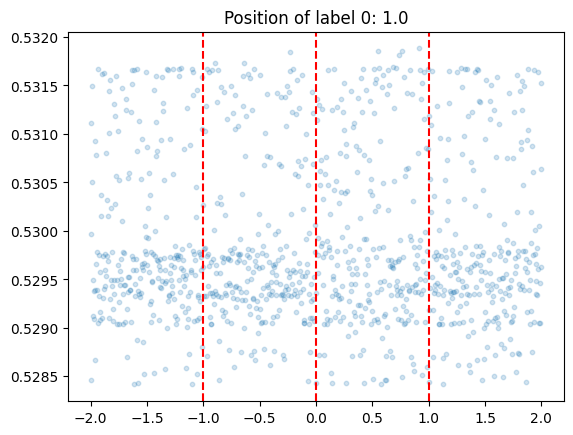

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Set the random seed for reproducibility
np.random.seed(12)

proba_at_0 = []
proba_labels_1_list = []

#num_points_minus_1_list = [10, 20, 50, 100, 250, 512]

#for num_points_minus_1 in num_points_minus_1_list:
num_points_minus_1 = 512
positions_label_0_list = [-2, -1.5, -1, -0.5, 0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.]

for positions_label_0 in positions_label_0_list:
    # Generate points randomly chosen from -1 and 1
    points_minus_1 = np.array([positions_label_0] * num_points_minus_1).reshape(-1, 1)
    # concatenate with a second random feature
    points_minus_1 = np.concatenate((points_minus_1, 2 * np.random.rand(num_points_minus_1).reshape(-1, 1) - 1), axis=1)
    labels_minus_1 = np.zeros(num_points_minus_1)
    points_1 = np.array([1] * 512).reshape(-1, 1)
    points_1 = np.concatenate((points_1, 2 * np.random.rand(len(points_1)).reshape(-1, 1) - 1), axis=1)
    labels_1 = np.ones(512)

    X = np.concatenate((points_minus_1, points_1))#.reshape(-1, 1)
    y = np.concatenate((labels_minus_1, labels_1))
    print(points_minus_1.shape, points_1.shape)
    print(X.shape, y.shape)
    # change a few labels at random with probability 0.05
    for i in range(len(y)):
        if np.random.rand() < 0.2:
            y[i] = 1 - y[i]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    tabpfn = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=True, normalize=False)
    tabpfn.fit(X_train, y_train)

    # show the prediction for points between -2 and 2
    X_pred = np.linspace(-2, 2, 1000).reshape(-1, 1)
    # add a random second feature
    X_pred = np.concatenate((X_pred, 2 * np.random.rand(len(X_pred)).reshape(-1, 1) - 1), axis=1)
    y_pred = tabpfn.predict_proba(X_pred)[:, 1]
    #y_pred_0 = tabpfn.predict_proba(X_pred)[:, 0]

    proba_at_0.append(y_pred[500])
    proba_labels_1 = tabpfn.predict_proba(points_1)[:, 1]
    proba_labels_1_list.append(np.mean(proba_labels_1))



    #plt.scatter(X_train, y_train, label="True", s=10, alpha=0.2)
    #plt.plot(X_pred, y_pred, label="Predicted")
    plt.scatter(X_pred[:, 0], y_pred, label="Predicted", s=10, alpha=0.2)
    # vertical line at -1, 0 and 1
    plt.axvline(-1, color='r', linestyle='--')
    plt.axvline(0, color='r', linestyle='--')
    plt.axvline(1, color='r', linestyle='--')
    #plt.plot(X_pred, y_pred_0, label="Predicted")
    plt.title(f"Position of label 0: {positions_label_0}")
    plt.show()





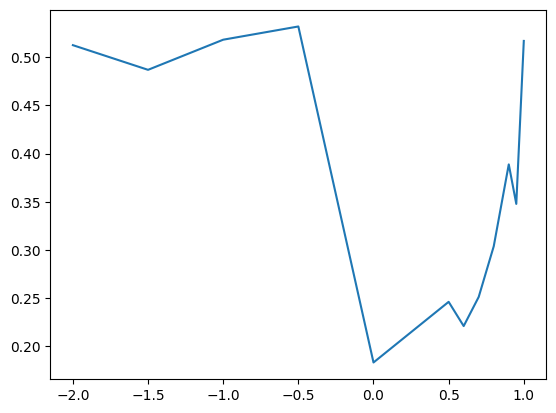

In [95]:
plt.plot(positions_label_0_list, proba_at_0, label="Proba at 0")

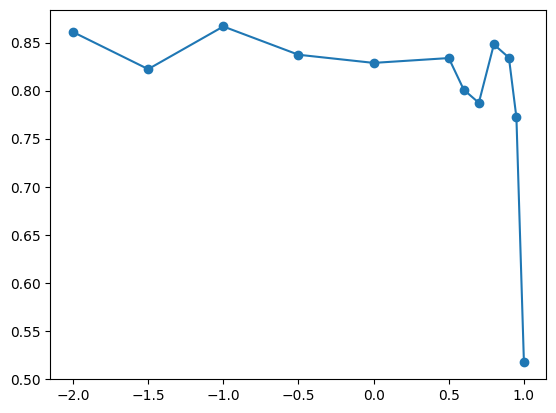

In [97]:
plt.plot(positions_label_0_list, proba_labels_1_list, label="Proba at 1", marker='o')

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


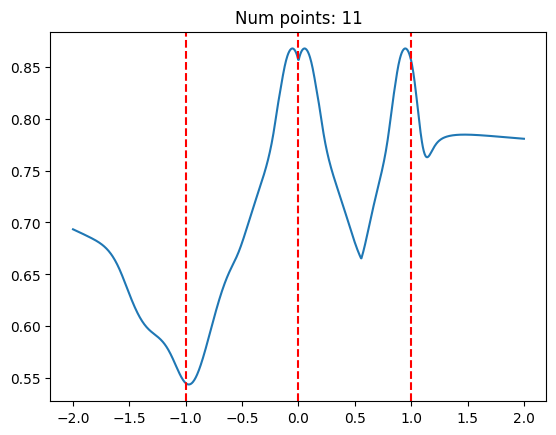

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


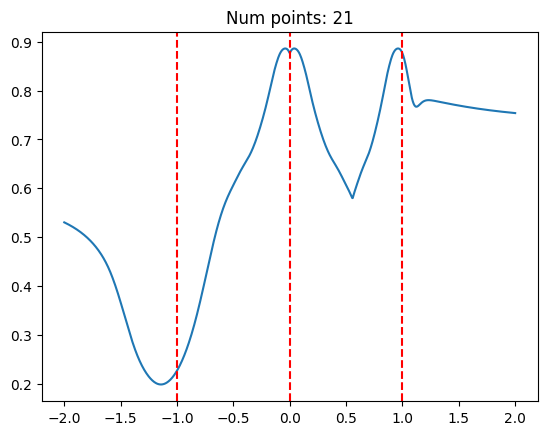

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


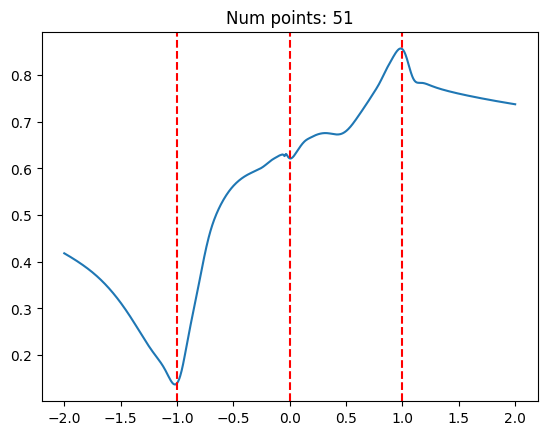

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


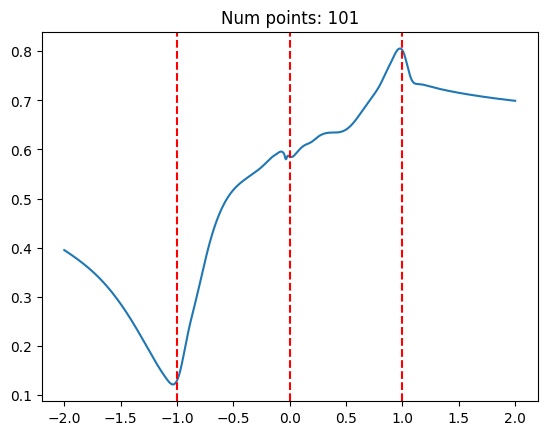

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


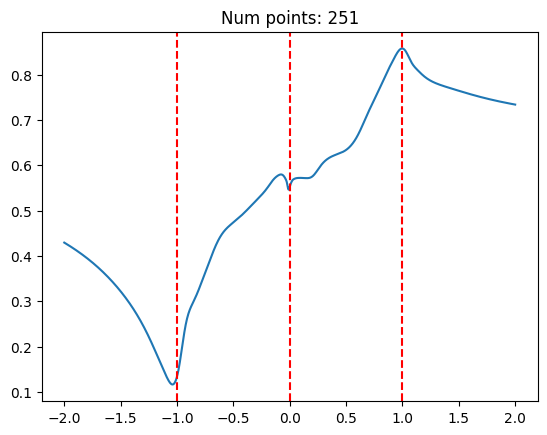

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


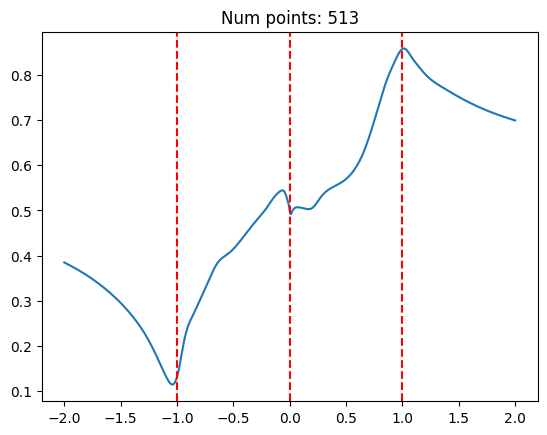

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Set the random seed for reproducibility
np.random.seed(12)

proba_at_0 = []

num_points_minus_1_list = [10, 20, 50, 100, 250, 512]

for num_points_minus_1 in num_points_minus_1_list:
    # Generate points randomly chosen from -1 and 1
    points_minus_1 = np.array([-1] * num_points_minus_1)
    labels_minus_1 = np.zeros(num_points_minus_1)
    points_1 = np.array([1] * 512)
    labels_1 = np.ones(512)

    X = np.concatenate((points_minus_1, points_1)).reshape(-1, 1)
    y = np.concatenate((labels_minus_1, labels_1))
    # change a few labels at random with probability 0.05
    for i in range(len(y)):
        if np.random.rand() < 0.2:
            y[i] = 1 - y[i]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    tabpfn = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=True, normalize=False)
    tabpfn.fit(X_train, y_train)

    # show the prediction for points between -2 and 2
    X_pred = np.linspace(-2, 2, 1000).reshape(-1, 1)
    y_pred = tabpfn.predict_proba(X_pred)[:, 1]
    #y_pred_0 = tabpfn.predict_proba(X_pred)[:, 0]

    proba_at_0.append(y_pred[500])

    #plt.scatter(X_train, y_train, label="True", s=10, alpha=0.2)
    plt.plot(X_pred, y_pred, label="Predicted")
    # vertical line at -1, 0 and 1
    plt.axvline(-1, color='r', linestyle='--')
    plt.axvline(0, color='r', linestyle='--')
    plt.axvline(1, color='r', linestyle='--')
    #plt.plot(X_pred, y_pred_0, label="Predicted")
    plt.title(f"Num points: {num_points_minus_1 + 1}")
    plt.show()





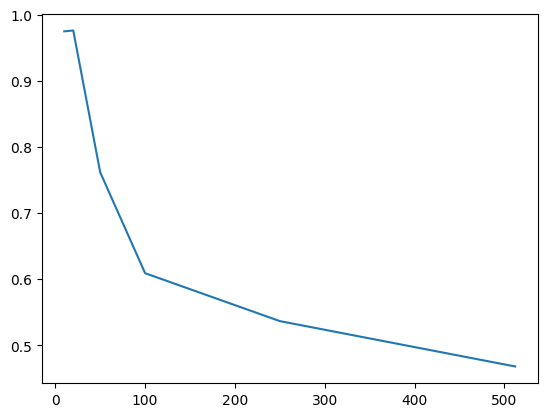

In [83]:
plt.plot(num_points_minus_1_list, proba_at_0)

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


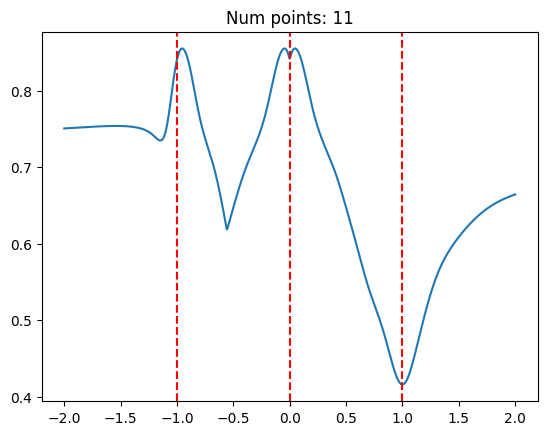

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


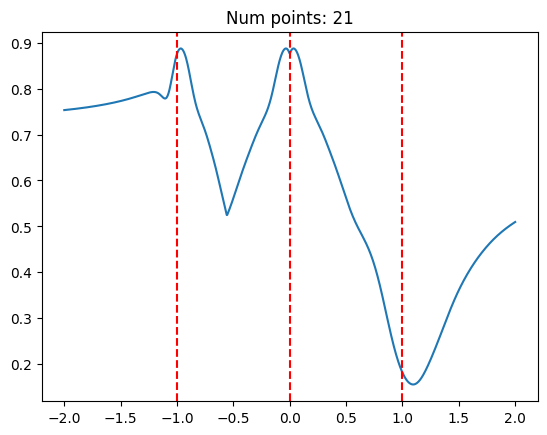

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


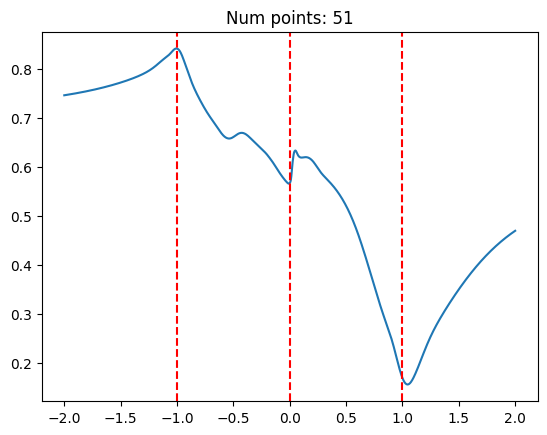

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


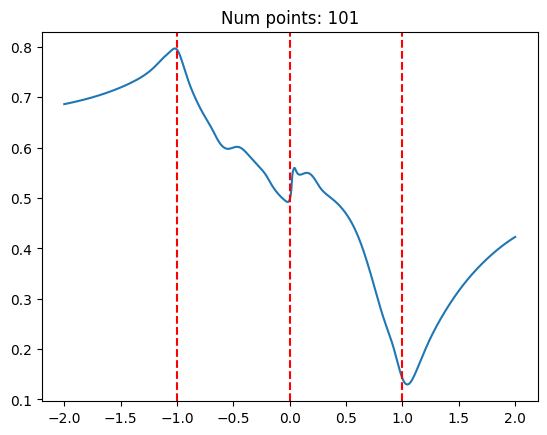

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


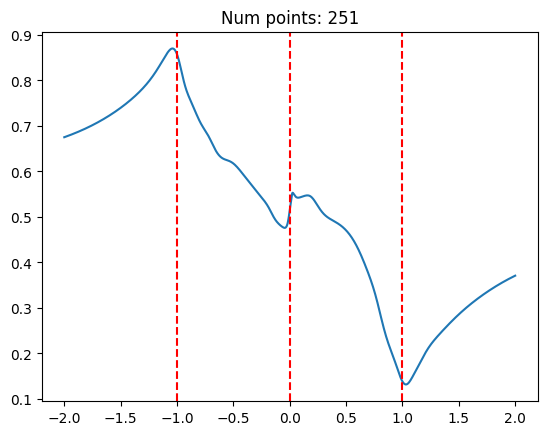

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


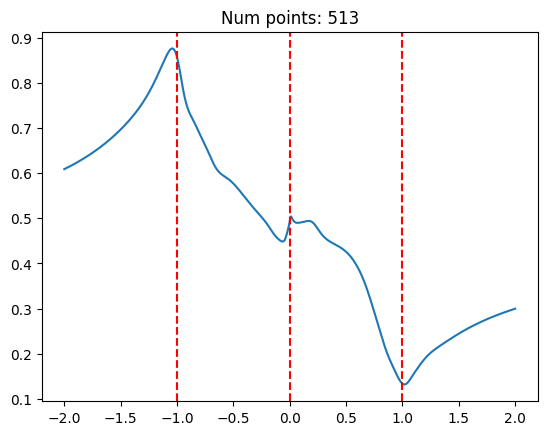

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Set the random seed for reproducibility
np.random.seed(12)

proba_at_0 = []

num_points_minus_1_list = [10, 20, 50, 100, 250, 512]

for num_points_minus_1 in num_points_minus_1_list:
    # Generate points randomly chosen from -1 and 1
    points_minus_1 = np.array([1] * num_points_minus_1)
    labels_minus_1 = np.zeros(num_points_minus_1)
    points_1 = np.array([-1] * 512)
    labels_1 = np.ones(512)

    X = np.concatenate((points_minus_1, points_1)).reshape(-1, 1)
    y = np.concatenate((labels_minus_1, labels_1))
    # change a few labels at random with probability 0.05
    for i in range(len(y)):
        if np.random.rand() < 0.2:
            y[i] = 1 - y[i]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    tabpfn = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=True, normalize=False)
    tabpfn.fit(X_train, y_train)

    # show the prediction for points between -2 and 2
    X_pred = np.linspace(-2, 2, 1000).reshape(-1, 1)
    y_pred = tabpfn.predict_proba(X_pred)[:, 1]
    #y_pred_0 = tabpfn.predict_proba(X_pred)[:, 0]

    proba_at_0.append(y_pred[500])

    #plt.scatter(X_train, y_train, label="True", s=10, alpha=0.2)
    plt.plot(X_pred, y_pred, label="Predicted")
    # vertical line at -1, 0 and 1
    plt.axvline(-1, color='r', linestyle='--')
    plt.axvline(0, color='r', linestyle='--')
    plt.axvline(1, color='r', linestyle='--')
    #plt.plot(X_pred, y_pred_0, label="Predicted")
    plt.title(f"Num points: {num_points_minus_1 + 1}")
    plt.show()





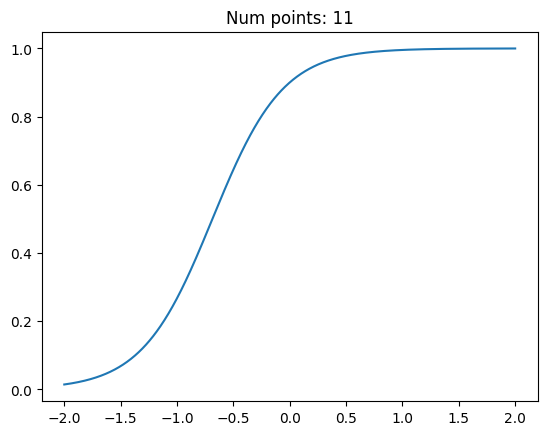

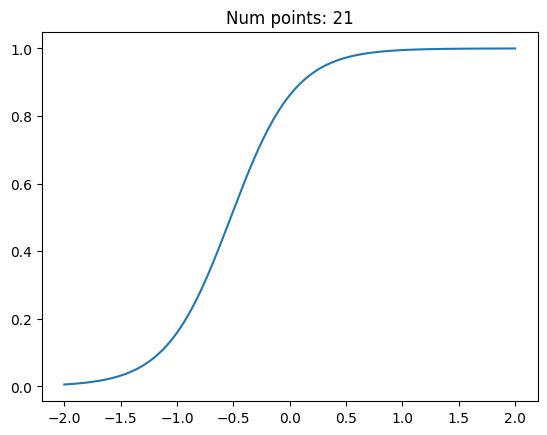

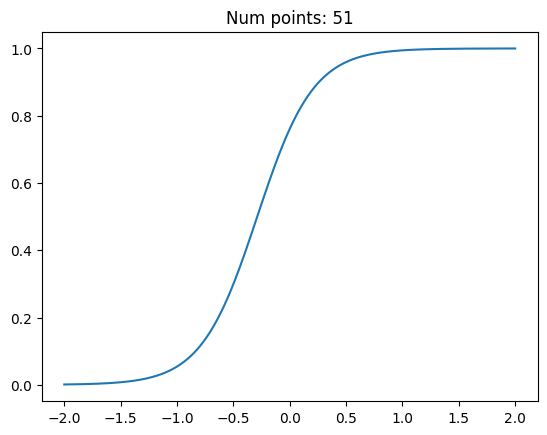

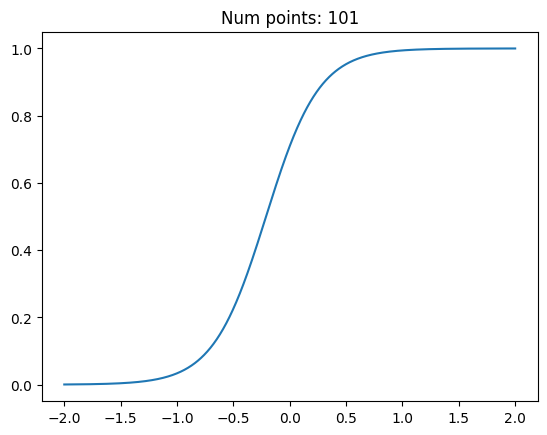

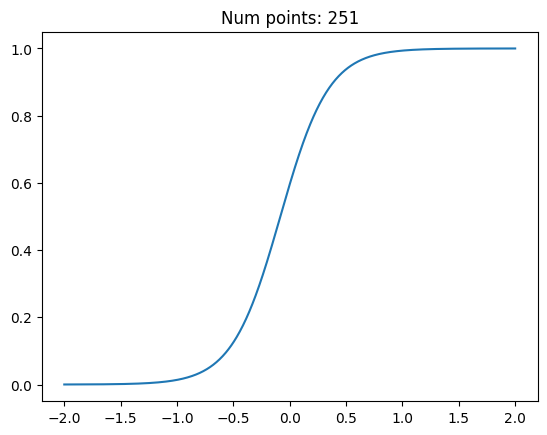

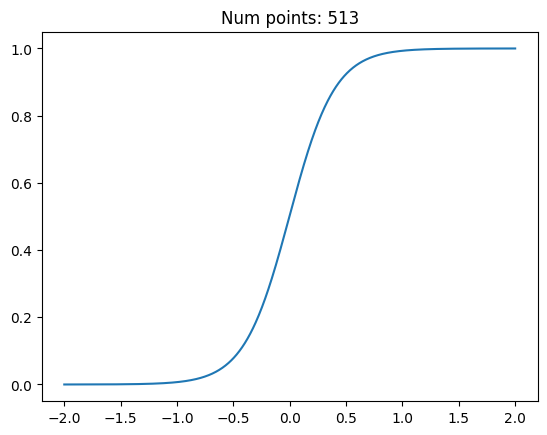

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Set the random seed for reproducibility
np.random.seed(42)


for num_points_minus_1 in [10, 20, 50, 100, 250, 512]:
    # Generate points randomly chosen from -1 and 1
    points_minus_1 = np.array([-1] * num_points_minus_1)
    labels_minus_1 = np.zeros(num_points_minus_1)
    points_1 = np.array([1] * 512)
    labels_1 = np.ones(512)

    X = np.concatenate((points_minus_1, points_1)).reshape(-1, 1)
    y = np.concatenate((labels_minus_1, labels_1))

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    #tabpfn = TabPFNClassifier(device=device, N_ensemble_configurations=5, no_preprocess_mode=False, normalize=True)
    tabpfn = LogisticRegression()
    tabpfn.fit(X_train, y_train)

    # show the prediction for points between -2 and 2
    X_pred = np.linspace(-2, 2, 1000).reshape(-1, 1)
    y_pred = tabpfn.predict_proba(X_pred)[:, 1]
    #y_pred_0 = tabpfn.predict_proba(X_pred)[:, 0]

    #plt.scatter(X_train, y_train, label="True", s=10, alpha=0.2)
    plt.plot(X_pred, y_pred, label="Predicted")
    #plt.plot(X_pred, y_pred_0, label="Predicted")
    plt.title(f"Num points: {num_points_minus_1 + 1}")
    plt.show()



